<a href="https://colab.research.google.com/github/LaZoark/anomaly_detection/blob/main/%5B%E6%B0%B4%E6%B3%B5%E9%A6%AC%E9%81%94%5Ddetect_predict_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
# 軸承競賽 train.csv
# !wget https://github.com/dreamingfish2011/ml_dl/raw/master/com/self/ml/classify/bearing/train.csv

# 江南大學 bearing datasets
# ! wget https://github.com/LaZoark/anomaly_detection/raw/main/Jiangnan_bearing/B600.csv
# ! wget https://github.com/LaZoark/anomaly_detection/raw/main/Jiangnan_bearing/B800.csv
# ! wget https://github.com/LaZoark/anomaly_detection/raw/main/Jiangnan_bearing/B1000.csv
# ! wget https://github.com/LaZoark/anomaly_detection/raw/main/Jiangnan_bearing/IR600.csv
# ! wget https://github.com/LaZoark/anomaly_detection/raw/main/Jiangnan_bearing/IR800.csv
# ! wget https://github.com/LaZoark/anomaly_detection/raw/main/Jiangnan_bearing/IR1000.csv
# ! wget https://github.com/LaZoark/anomaly_detection/raw/main/Jiangnan_bearing/OR600.csv
# ! wget https://github.com/LaZoark/anomaly_detection/raw/main/Jiangnan_bearing/OR800.csv
# ! wget https://github.com/LaZoark/anomaly_detection/raw/main/Jiangnan_bearing/OR1000.csv
# ! wget https://github.com/LaZoark/anomaly_detection/raw/main/Jiangnan_bearing/N600.csv
# ! wget https://github.com/LaZoark/anomaly_detection/raw/main/Jiangnan_bearing/N800.csv
# ! wget https://github.com/LaZoark/anomaly_detection/raw/main/Jiangnan_bearing/N1000.csv

In [85]:
import os
import pandas as pd
import numpy as np
import random
import datetime

import tensorflow as tf
import keras
from keras.layers import Dense
from keras import regularizers

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
import joblib

# import pymongo
# from pymongo import MongoClient
# import psycopg2
# from psycopg2.extras import execute_values

from matplotlib import pyplot as plt

# For reproducible results
# tf.random.set_seed(123456)
np.random.seed(123456)
random.seed(123456)

# Envs setting

In [86]:
# # deviceID
# deviceID = 'FF556D31'

# model saving path
save_path = 'training_model/'

# create model saving folder
if not os.path.exists('./training_model'):
    os.makedirs('./training_model')

In [87]:
config = {}
envs = {
    "deviceID": 'FF548D29',
    # "deviceID": 'bearing_comp',
}

In [88]:
for env, default in envs.items():
    config.update({
        env: os.getenv(env, default)
    })
print(config)

{'deviceID': 'FF548D29'}


In [89]:
E_model_name = config['deviceID'] +"_pretrain_encoder.h5"
D_model_name = config['deviceID'] +"_pretrain_decoder.h5"

M_model_name = config['deviceID'] +"_metatrain_encoder.h5"
MF_model_name = config['deviceID'] +"_metatrain_decoder.h5"

PF_model_name = config['deviceID'] +"_ft_decoder.h5"
MFR_model_name = config['deviceID'] +"_meta_reft_decoder.h5"

scalers = config['deviceID'] +"_scaler.h5"
train_dataset = config['deviceID'] +"_Train.csv"
inference_dataset = config['deviceID'] +"_Test.csv"
Inference_result_name = config['deviceID'] +"_inference_result"

In [90]:
metatrain_encoder_model = save_path + M_model_name
metatrain_refinetune_decoder_model = save_path + MFR_model_name

pretrain_encoder_model = save_path + E_model_name
pretrain_decoder_model = save_path + D_model_name

metatrain_finetune_decoder_model = save_path + MF_model_name
pretrain_finetune_decoder_model = save_path + PF_model_name

pretrain_scaler_name = save_path + scalers
Train_dataset = train_dataset

# Load 7 days Data from datahub

In [91]:
# data = download_from_datahub(config['deviceID'])
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
_path = ['/content/drive/MyDrive/[研華科技]水泵聯軸器與馬達raw data/fine_水泵聯軸器_20211116.csv',
         '/content/drive/MyDrive/[研華科技]水泵聯軸器與馬達raw data/水泵馬達_20211116.csv',
         '/content/train.csv',
         '/content/N600.csv',
]

if envs['deviceID'] == 'FF548D29':
    # data = pd.read_csv(_path[0], encoding='utf-8')
    data = pd.read_csv(_path[1], encoding='utf-8')
else:
    # data = pd.read_csv(_path[2], encoding='utf-8', index_col='id')
    data = pd.read_csv(_path[3], encoding='utf-8')

In [93]:
def delete_outlier(df, name):    
    df_value = df[name]
    s = df_value.copy()
    zscore = s - s.mean()
    sigma = s.std()
    df['isOutlier'] = zscore.abs() > 6 * sigma
    #找出在3 sigma內的正常值
    df_in = df[df['isOutlier'] == False]
    df_in2 = df_in.drop(['isOutlier'],axis=1)

    return df_in2

In [94]:
#drop "id"
# data.drop(data.columns[0], axis=1, inplace=True)
data

,Time,X_CrestFactor,X_Deviation,X_Displacement,X_Kurtosis,X_OAVelocity,X_Peakmg,X_RMSmg,X_Skewness,Y_CrestFactor,...,Z_OAVelocity,Z_Peakmg,Z_RMSmg,Z_Skewness,Temp_SenVal,INV.HZ,INV.KW,RPM,motor級數,DESCRIPION
0,2021/8/26 16:09,641,4,99,418,242,47,33,-30,571,...,243,53,37,-206,40187,53.50,65.5805,3600,2,motor
1,2021/8/26 17:07,349,66,119,-8,761,799,565,-5,300,...,556,490,346,7,40125,53.66,65.1292,3600,2,motor
2,2021/8/26 17:34,370,67,122,-5,769,811,573,-4,115,...,553,495,350,6,40562,53.57,65.4157,3600,2,motor
3,2021/8/26 18:09,401,67,133,0,797,806,570,-1,89,...,571,498,352,8,40625,53.64,64.5726,3600,2,motor
4,2021/8/26 19:09,365,67,120,2,806,813,574,-9,170,...,577,501,354,8,40812,53.55,65.4052,3600,2,motor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,2021/9/28 06:11,368,80,134,0,865,1004,710,-20,69,...,621,511,361,6,40937,53.51,63.1464,3600,2,motor
664,2021/9/28 07:11,320,80,127,-6,852,1005,711,-19,144,...,608,509,360,0,40875,53.43,63.2233,3600,2,motor
665,2021/9/28 08:11,357,83,139,8,869,1025,725,-23,182,...,645,523,370,2,40750,53.51,63.5917,3600,2,motor
666,2021/9/28 10:11,353,80,125,2,841,995,703,-20,271,...,621,510,360,3,40812,53.40,63.3968,3600,2,motor


Index(['Time', 'X_CrestFactor', 'X_Deviation', 'X_Displacement', 'X_Kurtosis',
       'X_OAVelocity', 'X_Peakmg', 'X_RMSmg', 'X_Skewness', 'Y_CrestFactor',
       'Y_Deviation', 'Y_Displacement', 'Y_Kurtosis', 'Y_OAVelocity',
       'Y_Peakmg', 'Y_RMSmg', 'Y_Skewness', 'Z_CrestFactor', 'Z_Deviation',
       'Z_Displacement', 'Z_Kurtosis', 'Z_OAVelocity', 'Z_Peakmg', 'Z_RMSmg',
       'Z_Skewness', 'Temp_SenVal', ' INV.HZ', ' INV.KW', 'RPM', 'motor級數',
       'DESCRIPION'],
      dtype='object')


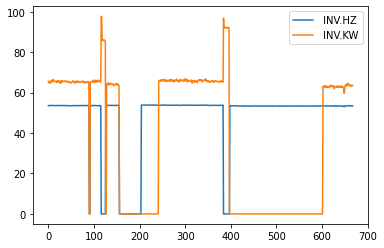

In [95]:
print(data.columns)
if envs['deviceID'] == 'FF548D29':
    try:
        data['INV.HZ'].plot()
        data['INV.KW'].plot()
    except:
        data[' INV.HZ'].plot()
        data[' INV.KW'].plot()
    plt.legend()

In [96]:
if envs['deviceID'] == 'FF548D29':
    feature24=['X_OAVelocity', 'Y_OAVelocity', 'Z_OAVelocity',
                'X_Peakmg', 'Y_Peakmg', 'Z_Peakmg', 
                'X_RMSmg', 'Y_RMSmg', 'Z_RMSmg',
                'X_Kurtosis', 'Y_Kurtosis', 'Z_Kurtosis', 
                'X_CrestFactor', 'Y_CrestFactor', 'Z_CrestFactor', 
                'X_Skewness', 'Y_Skewness','Z_Skewness',
                'X_Deviation', 'Y_Deviation', 'Z_Deviation',
                'X_Displacement', 'Y_Displacement', 'Z_Displacement']


    # show NA rows in the dataframe
    df_NA = data[data.isnull().values==True]   #显示存在缺失值的行列

    data = data.dropna() #剔除缺失行
    data = data.drop_duplicates() #剔除重复行

    # delete outlier rows 剔除异常行
    
    for i in range(len(feature24)):
        data = delete_outlier(data, feature24[i])

# 備份初步清理過後的原始資料
rawdata = data.copy()

In [97]:
def plot_data(_data):
    data_columns = list(_data.columns)
    for i in data_columns:
        try:
            fig, ax = plt.subplots()
            plt.title(i)
            _data[i].plot(ax=ax)
            plt.show()
        except:
            print(i)

# plot_data(rawdata[:][0])

In [98]:
# data[0:5000].plot()

In [99]:
rawdata.iloc[1]
# rawdata['label']

Time              2021/8/26 17:34
X_CrestFactor                 370
X_Deviation                    67
X_Displacement                122
X_Kurtosis                     -5
X_OAVelocity                  769
X_Peakmg                      811
X_RMSmg                       573
X_Skewness                     -4
Y_CrestFactor                 115
Y_Deviation                    65
Y_Displacement                 87
Y_Kurtosis                     -3
Y_OAVelocity                  573
Y_Peakmg                      853
Y_RMSmg                       603
Y_Skewness                     -6
Z_CrestFactor                 414
Z_Deviation                    39
Z_Displacement                 66
Z_Kurtosis                     -3
Z_OAVelocity                  553
Z_Peakmg                      495
Z_RMSmg                       350
Z_Skewness                      6
Temp_SenVal                 40562
 INV.HZ                     53.57
 INV.KW                   65.4157
RPM                          3600
motor級數       

In [100]:
if envs['deviceID'] == 'FF548D29':
    data_24_no_abnormal = data.reindex(columns=feature24)
    print('data_24_no_abnormal: ', data_24_no_abnormal.shape)
else:
    data_normal = rawdata[rawdata['label']==0]
    data_normal.drop('label', axis=1, inplace=True)
    print('normal data: ', data_normal.shape)

data_24_no_abnormal:  (667, 24)


# Normailize

In [101]:
if envs['deviceID'] == 'FF548D29':
    Xy_drop = data_24_no_abnormal.copy()
else:
    Xy_drop = data_normal.copy()

scaler = MinMaxScaler().fit(Xy_drop)
norm_data = scaler.transform(Xy_drop)
norm_data = pd.DataFrame(norm_data)

In [102]:
# Normailze scaler save to assigned folder path
joblib.dump(scaler, pretrain_scaler_name)

['training_model/FF548D29_scaler.h5']

# Make dataset

In [103]:
pid=0
# Normalize

#P(Pretrain) M(Metatrain)
P_M_data = int(norm_data.shape[0]*0.4)
#F(Finetune) T(Test)
F_T_data = int(norm_data.shape[0]*0.2)

t1P = P_M_data
t1M = t1P + P_M_data
t1F = t1M + F_T_data
# t1T = t1F + F_T_data
# t2M = t1T + P_M_data
# t2F = t2M + F_T_data
# t2T = t2F + F_T_data
# t3F = t2T + F_T_data
# t3T = t3F + F_T_data

######################### t1 data##############################################

# Training data for pretrain stage
norm_Xy_drop_df = norm_data.iloc[0:t1P]

# 將資料分成Train與Test
x_train, x_test = train_test_split(norm_Xy_drop_df, test_size=0.2, random_state=0)

# save splited set
if not os.path.exists('./norm_data/pretrain/%d'%(pid+1)):
    os.makedirs('./norm_data/pretrain/%d'%(pid+1))
x_train.to_csv('./norm_data/pretrain/%d/train.csv'%(pid+1), index=False)
x_test.to_csv('./norm_data/pretrain/%d/test.csv'%(pid+1), index=False)


# Training data for meta stage
norm_Xy_drop_df = norm_data.iloc[t1P:t1M]

# split train and test set
x_train, x_test = train_test_split(norm_Xy_drop_df, test_size=0.2, random_state=0)

# save splited set
if not os.path.exists('./norm_data/meta/%d'%(pid+1)):
    os.makedirs('./norm_data/meta/%d'%(pid+1))
x_train.to_csv('./norm_data/meta/%d/train.csv'%(pid+1), index=False)
x_test.to_csv('./norm_data/meta/%d/test.csv'%(pid+1), index=False)

# Training data for ft stage
norm_Xy_drop_df = norm_data.iloc[t1M:t1F] 

# split train and test set
x_train, x_test = train_test_split(norm_Xy_drop_df, test_size=0.8, random_state=0)

# save splited set
if not os.path.exists('./norm_data/ft/%d'%(pid+1)):
    os.makedirs('./norm_data/ft/%d'%(pid+1))
x_train.to_csv('./norm_data/ft/%d/train.csv'%(pid+1), index=False)
x_test.to_csv('./norm_data/ft/%d/test.csv'%(pid+1), index=False)


# # Test data
# x_test = norm_data.iloc[t1F:t1T]

# # save splited set
# if not os.path.exists('./norm_data/test/%d'%(pid+1)):
#     os.makedirs('./norm_data/test/%d'%(pid+1))
# x_test.to_csv('./norm_data/test/%d/test.csv'%(pid+1), index=False)

print('t1 ok')

t1 ok


In [104]:
x_train

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
604,0.584151,0.874292,0.902054,0.888229,0.889205,0.952756,0.888268,0.887701,0.952646,0.650794,...,0.455285,0.145455,0.516129,0.581395,0.800000,0.8875,0.863636,0.666667,0.619266,0.816092
609,0.587925,0.830125,0.903633,0.911968,0.844697,0.942913,0.912011,0.843583,0.941504,0.984127,...,0.471545,0.018182,0.612903,0.465116,0.822222,0.8500,0.863636,0.650538,0.610092,0.735632
557,0.580377,0.867497,0.911532,0.843719,0.895833,0.956693,0.843575,0.895722,0.955432,0.761905,...,0.382114,0.145455,0.483871,0.534884,0.766667,0.9000,0.863636,0.639785,0.669725,0.781609
569,0.598491,0.870895,0.943128,0.885262,0.900568,0.950787,0.884078,0.899733,0.949861,0.682540,...,0.276423,0.145455,0.645161,0.441860,0.800000,0.9125,0.863636,0.623656,0.646789,0.701149
613,0.577358,0.869762,0.906793,0.917903,0.858902,0.958661,0.917598,0.858289,0.958217,0.761905,...,0.463415,0.090909,0.451613,0.627907,0.822222,0.8625,0.863636,0.602151,0.706422,0.747126
652,0.606038,0.738392,0.740916,0.845697,0.739583,0.826772,0.846369,0.737968,0.827298,0.349206,...,0.276423,0.381818,0.419355,0.976744,0.700000,0.8000,0.681818,0.456989,0.444954,0.517241
578,0.601509,0.875425,0.946288,0.868447,0.875000,0.970472,0.868715,0.874332,0.969359,0.809524,...,0.487805,0.109091,0.419355,0.465116,0.788889,0.8750,0.863636,0.672043,0.655963,0.816092
655,0.633962,0.795017,0.928910,0.982196,0.758523,0.950787,0.981844,0.758021,0.949861,0.682540,...,0.626016,0.054545,0.354839,0.651163,0.900000,0.7875,0.909091,0.645161,0.555046,0.758621
571,0.589434,0.876557,0.922591,0.864491,0.869318,0.962598,0.864525,0.868984,0.963788,0.936508,...,0.520325,0.127273,0.483871,0.488372,0.777778,0.8750,0.863636,0.661290,0.688073,0.758621
634,0.608302,0.930917,0.913112,0.940653,0.911932,0.960630,0.939944,0.910428,0.961003,0.746032,...,0.447154,0.072727,0.322581,0.465116,0.844444,0.9125,0.863636,0.725806,0.788991,0.758621


# Pretrain stage

In [105]:
pretrain_train_path = './norm_data/pretrain/1/train.csv'
pretrain_val_path = './norm_data/pretrain/1/test.csv'
x_train = pd.read_csv(pretrain_train_path, dtype=np.float32)
x_test = pd.read_csv(pretrain_val_path, dtype=np.float32)

In [106]:
# nb_epoch_number = 300
nb_epoch_number = 50

In [107]:
nb_epoch = nb_epoch_number #50
batch_size = 10
input_dim = x_train.shape[1] #num of predictor variables,  (24)
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
lr_regularizers = 1e-3

input_layer = keras.layers.Input(shape=(input_dim, ))
x = Dense(encoding_dim, activation="relu", 
                       activity_regularizer=regularizers.l1(lr_regularizers), name="enc_layer1")(input_layer)
x = Dense(hidden_dim, activation="relu", name="enc_layer2")(x)
x = Dense(int(hidden_dim/2), activation="relu", name="enc_layer3")(x)
encoder_output = Dense(int(hidden_dim/4), activation="relu", name="enc_layer4")(x)

encoder = keras.Model(input_layer, encoder_output, name="encoder")

decoder_input = keras.layers.Input(shape=(int(hidden_dim/4),))
x = Dense(int(encoding_dim/4), activation="relu", name="dec_layer1")(decoder_input)
x = Dense(int(encoding_dim/2), activation="relu", name="dec_layer2")(x)
x = Dense(encoding_dim, activation="relu", name="dec_layer3")(x)
decoder_output = Dense(input_dim, activation="linear", name="dec_layer4")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")

autoencoder_input = keras.layers.Input(shape=(input_dim, ), name="input")
encoded_sig = encoder(autoencoder_input)
decoded_sig = decoder(encoded_sig)
autoencoder = keras.models.Model(autoencoder_input, decoded_sig, name="autoencoder")

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 24)]              0         
                                                                 
 encoder (Functional)        (None, 4)                 1500      
                                                                 
 decoder (Functional)        (None, 24)                1520      
                                                                 
Total params: 3,020
Trainable params: 3,020
Non-trainable params: 0
_________________________________________________________________


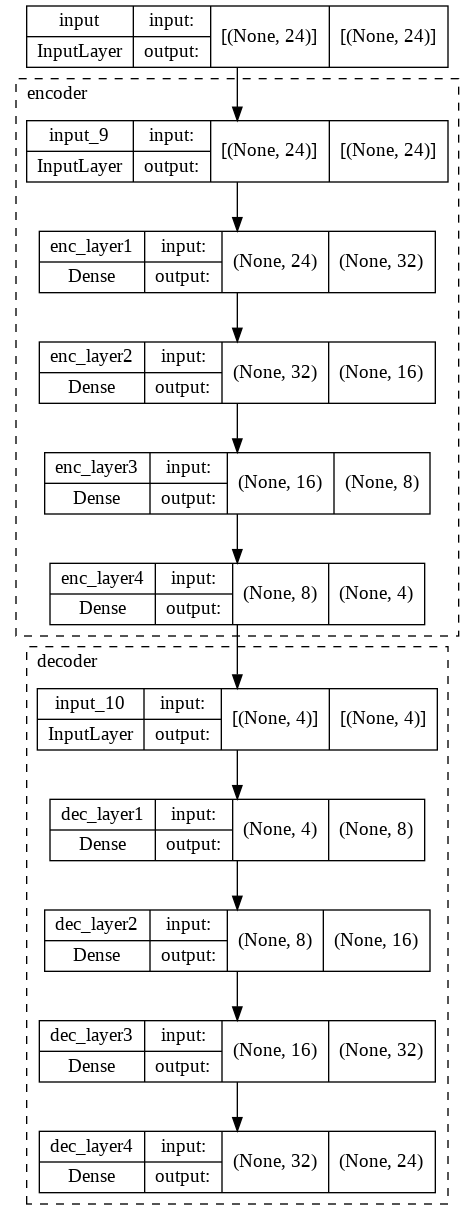

In [108]:
autoencoder.summary()

tf.keras.utils.plot_model(autoencoder, to_file='model_1.png', show_shapes=True,
                        expand_nested=True,
                        show_layer_activations=True,
                        )

In [109]:
learning_rate = 3e-4
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

autoencoder.compile(loss='mean_squared_error', optimizer=adam)

es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

In [110]:
# 因為AE要重建input，希望透過重建誤差來找到異常
AE_history = autoencoder.fit( x_train.to_numpy(), #input y=0的資料
                              x_train.to_numpy(), #與decoder比對 y=0的資料
                              epochs=nb_epoch,
                              batch_size=batch_size,
                              shuffle=True,
                              validation_data=(x_test.to_numpy(), x_test.to_numpy()),
                              verbose=1,
                              callbacks=[es]).history

Epoch 1/50
22/22 [==============================] - 1s 13ms/step - loss: 0.4149 - val_loss: 0.3862
Epoch 2/50
22/22 [==============================] - 0s 3ms/step - loss: 0.4016 - val_loss: 0.3737
Epoch 3/50
22/22 [==============================] - 0s 5ms/step - loss: 0.3873 - val_loss: 0.3593
Epoch 4/50
22/22 [==============================] - 0s 5ms/step - loss: 0.3705 - val_loss: 0.3413
Epoch 5/50
22/22 [==============================] - 0s 4ms/step - loss: 0.3484 - val_loss: 0.3158
Epoch 6/50
22/22 [==============================] - 0s 4ms/step - loss: 0.3133 - val_loss: 0.2702
Epoch 7/50
22/22 [==============================] - 0s 4ms/step - loss: 0.2505 - val_loss: 0.2001
Epoch 8/50
22/22 [==============================] - 0s 5ms/step - loss: 0.1685 - val_loss: 0.1293
Epoch 9/50
22/22 [==============================] - 0s 5ms/step - loss: 0.1092 - val_loss: 0.0931
Epoch 10/50
22/22 [==============================] - 0s 5ms/step - loss: 0.0784 - val_loss: 0.0720
Epoch 11/50
22/22 

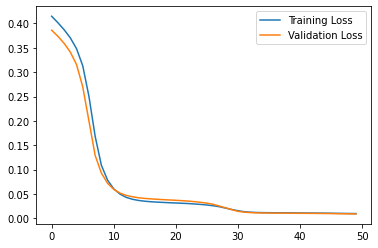

In [111]:
plt.plot(AE_history["loss"], label="Training Loss")
plt.plot(AE_history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [112]:
encoder.save(pretrain_encoder_model) #save encoder weights
decoder.save(pretrain_decoder_model) #save decoder weights

In [113]:
# RMSE受異常值的影響更大
def RMSE_cal(model,x,y):
    ypred = model.predict(x)
    MSE = mean_squared_error(y, ypred)
    RMSE = np.sqrt(MSE)
    return RMSE

In [114]:
trainRMSE = RMSE_cal(autoencoder,x_train.to_numpy(), x_train.to_numpy())
print('trainRMSE: ', trainRMSE)

testRMSE = RMSE_cal(autoencoder,x_test.to_numpy(), x_test.to_numpy())
print('testRMSE: ', testRMSE)

trainRMSE:  0.08479179
testRMSE:  0.081590295


# Meta-learning Stage

In [115]:
meta_train_path = './norm_data/meta/1/train.csv'
meta_val_path = './norm_data/meta/1/test.csv'
x_train = pd.read_csv(pretrain_train_path, dtype=np.float32)
x_test = pd.read_csv(pretrain_val_path, dtype=np.float32)

x_train_list = [x_train, pd.read_csv(meta_train_path, dtype=np.float32)]
x_test_list = [x_test, pd.read_csv(meta_val_path, dtype=np.float32)]

num_file = 1
# for i in range(num_file):
#     meta_train_path = './norm_data/meta/%d/train.csv'%(i+1)
#     meta_val_path = './norm_data/meta/%d/test.csv'%(i+1)
#     x_train_list.append(pd.read_csv(meta_train_path, dtype=np.float32))
#     x_test_list.append(pd.read_csv(meta_val_path, dtype=np.float32))

In [116]:
nb_epoch = nb_epoch_number
batch_size = 10
input_dim = x_train_list[0].shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
lr_regularizers = 1e-3

In [117]:
train_dataset = tf.data.Dataset.from_tensor_slices(tuple([data.to_numpy() for data in x_train_list])).shuffle(len(x_train_list[0])).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices(tuple([data.to_numpy() for data in x_test_list])).batch(1)

In [118]:
input_layer = keras.layers.Input(shape=(input_dim, ))
x = Dense(encoding_dim, activation="relu", 
                activity_regularizer=regularizers.l1(lr_regularizers), name="enc_layer1")(input_layer)
x = Dense(hidden_dim, activation="relu", name="enc_layer2")(x)
x = Dense(int(hidden_dim/2), activation="relu", name="enc_layer3")(x)
encoder_output = Dense(int(hidden_dim/4), activation="relu", name="enc_layer4")(x)

encoder = keras.Model(input_layer, encoder_output, name="encoder")

decoder_input = keras.layers.Input(shape=(int(hidden_dim/4),))
x = Dense(int(encoding_dim/4), activation="relu", name="dec_layer1")(decoder_input)
x = Dense(int(encoding_dim/2), activation="relu", name="dec_layer2")(x)
x = Dense(encoding_dim, activation="relu", name="dec_layer3")(x)
decoder_output = Dense(input_dim, activation="linear", name="dec_layer4")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")

encoder.compile() # 避免報錯(warning)
decoder.compile()
encoder.summary()
decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 24)]              0         
                                                                 
 enc_layer1 (Dense)          (None, 32)                800       
                                                                 
 enc_layer2 (Dense)          (None, 16)                528       
                                                                 
 enc_layer3 (Dense)          (None, 8)                 136       
                                                                 
 enc_layer4 (Dense)          (None, 4)                 36        
                                                                 
Total params: 1,500
Trainable params: 1,500
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
________________________________________

In [119]:
encoder.load_weights(pretrain_encoder_model, by_name=True)
decoder_list = []
for i in range(2):
    decoder_list.append(keras.models.clone_model(decoder))
    decoder_list[-1].load_weights(pretrain_decoder_model, by_name=True)

In [120]:
learning_rate = 1e-5
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# loss_fn = tf.keras.losses.MeanSquaredError()
loss_fn = keras.losses.MeanSquaredError()

In [121]:
best_val_loss = 999

for ep in range(nb_epoch):
    for bid, x in enumerate(train_dataset):
        #Phase 1: Fix enc, train different dec with only one batch
        if bid == 0:
            x_dec = x

        for i in range(num_file):
            with tf.GradientTape() as tape:
                hidden = encoder(x_dec[i])
                recon = decoder_list[i](hidden)
                loss = loss_fn(x_dec[i], recon)

            gradients = tape.gradient(loss, decoder_list[i].trainable_weights)
            adam.apply_gradients(zip(gradients, decoder_list[i].trainable_weights))

        #Phase 2: Fix dec, train meta encoder
        if bid != 0:
            for i in range(2):
                with tf.GradientTape() as tape:
                    hidden = encoder(x[i])
                    recon = decoder_list[i](hidden)
                    loss = loss_fn(x[i], recon)

                gradients = tape.gradient(loss, encoder.trainable_weights)
                adam.apply_gradients(zip(gradients, encoder.trainable_weights))


    val_loss = []
    for bid, x in enumerate(val_dataset):
        for i in range(num_file):   
            hidden = encoder(x[i])
            recon = decoder_list[i](hidden)
            loss = loss_fn(x[i], recon)
            val_loss.append(loss.numpy())
            
    print("\nEpoch: %d\tval_loss: %f"%(ep+1, np.mean(val_loss)), end='\t')
    
    if np.mean(val_loss) < best_val_loss:           # 跌代出最好的loss
        encoder.save(metatrain_encoder_model)
        best_val_loss = np.mean(val_loss)
        print("Save best model at ep %d"%(ep+1), end='')


Epoch: 1	val_loss: 0.006664	Save best model at ep 1

Epoch: 2	val_loss: 0.006648	Save best model at ep 2

Epoch: 3	val_loss: 0.006664	
Epoch: 4	val_loss: 0.006650	
Epoch: 5	val_loss: 0.006637	Save best model at ep 5

Epoch: 6	val_loss: 0.006637	
Epoch: 7	val_loss: 0.006645	
Epoch: 8	val_loss: 0.006612	Save best model at ep 8

Epoch: 9	val_loss: 0.006605	Save best model at ep 9

Epoch: 10	val_loss: 0.006611	
Epoch: 11	val_loss: 0.006637	
Epoch: 12	val_loss: 0.006644	
Epoch: 13	val_loss: 0.006630	
Epoch: 14	val_loss: 0.006624	
Epoch: 15	val_loss: 0.006614	
Epoch: 16	val_loss: 0.006606	
Epoch: 17	val_loss: 0.006592	Save best model at ep 17

Epoch: 18	val_loss: 0.006590	Save best model at ep 18

Epoch: 19	val_loss: 0.006606	
Epoch: 20	val_loss: 0.006598	
Epoch: 21	val_loss: 0.006600	
Epoch: 22	val_loss: 0.006608	
Epoch: 23	val_loss: 0.006607	
Epoch: 24	val_loss: 0.006591	
Epoch: 25	val_loss: 0.006603	
Epoch: 26	val_loss: 0.006596	
Epoch: 27	val_loss: 0.006593	
Epoch: 28	val_loss: 0.006590

# Fine-tuning Stage (Meta)

In [122]:
x_train_list = []
x_test_list = []
# num_file = 3
num_file = 1
for i in range(num_file):
    ft_train_path = './norm_data/ft/%d/train.csv'%(i+1)
    ft_val_path = './norm_data/ft/%d/test.csv'%(i+1)
    x_train_list.append(pd.read_csv(ft_train_path, dtype=np.float32))
    x_test_list.append(pd.read_csv(ft_val_path, dtype=np.float32))

In [123]:
print(x_train_list[0].shape)
print(x_test_list[0].shape)

(26, 24)
(107, 24)


In [124]:
nb_epoch = nb_epoch_number
batch_size = 10
#batch_size = 1
input_dim = x_train_list[0].shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
lr_regularizers = 1e-3

In [125]:
train_dataset = tf.data.Dataset.from_tensor_slices(tuple([data.to_numpy() for data in x_train_list])).shuffle(len(x_train_list[0])).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices(tuple([data.to_numpy() for data in x_test_list])).batch(1)

In [126]:
input_layer = keras.layers.Input(shape=(input_dim, ))
x = Dense(encoding_dim, activation="relu", 
                activity_regularizer=regularizers.l1(lr_regularizers), name="enc_layer1")(input_layer)
x = Dense(hidden_dim, activation="relu", name="enc_layer2")(x)
x = Dense(int(hidden_dim/2), activation="relu", name="enc_layer3")(x)
encoder_output = Dense(int(hidden_dim/4), activation="relu", name="enc_layer4")(x)

encoder = keras.Model(input_layer, encoder_output, name="encoder")

decoder_input = keras.layers.Input(shape=(int(hidden_dim/4),))
x = Dense(int(encoding_dim/4), activation="relu", name="dec_layer1")(decoder_input)
x = Dense(int(encoding_dim/2), activation="relu", name="dec_layer2")(x)
x = Dense(encoding_dim, activation="relu", name="dec_layer3")(x)
decoder_output = Dense(input_dim, activation="linear", name="dec_layer4")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")

# encoder.compile()
# decoder.compile()
encoder.summary()
decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 24)]              0         
                                                                 
 enc_layer1 (Dense)          (None, 32)                800       
                                                                 
 enc_layer2 (Dense)          (None, 16)                528       
                                                                 
 enc_layer3 (Dense)          (None, 8)                 136       
                                                                 
 enc_layer4 (Dense)          (None, 4)                 36        
                                                                 
Total params: 1,500
Trainable params: 1,500
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
________________________________________

In [127]:
encoder.load_weights(metatrain_encoder_model, by_name=True)
decoder_list = []
for i in range(num_file):
    decoder_list.append(keras.models.clone_model(decoder))
    decoder_list[-1].load_weights(pretrain_decoder_model, by_name=True)
    decoder_list[i].compile()

In [128]:
learning_rate = 1e-5
adam = tf.keras.optimizers.Adam(lr=learning_rate)

loss_fn = tf.keras.losses.MeanSquaredError()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [129]:
for i in range(num_file):
    print(metatrain_finetune_decoder_model)

training_model/FF548D29_metatrain_decoder.h5


In [130]:
best_val_loss = [999 for i in range(num_file)]

for ep in range(nb_epoch):
    for bid, x in enumerate(train_dataset):
        #only ft dec in ft stage
        for i in range(num_file):
            with tf.GradientTape() as tape:
                hidden = encoder(x[i])
                recon = decoder_list[i](hidden)
                loss = loss_fn(x[i], recon)

            gradients = tape.gradient(loss, decoder_list[i].trainable_weights)
            adam.apply_gradients(zip(gradients, decoder_list[i].trainable_weights))

    val_loss_list = [[] for i in range(num_file)]
    for bid, x in enumerate(val_dataset):
        for i in range(num_file):   
            hidden = encoder(x[i])
            recon = decoder_list[i](hidden)
            loss = loss_fn(x[i], recon)
            val_loss_list[i].append(loss.numpy())
    
    print("Epoch: %d"%(ep+1), end='\t')
    for i in range(num_file):
        print("file %d val_loss: %f"%(i+1, np.mean(val_loss_list[i])))

        if np.mean(val_loss_list[i]) < best_val_loss[i]:
            decoder_list[i].save(metatrain_finetune_decoder_model)
            best_val_loss[i] = np.mean(val_loss_list[i])

Epoch: 1	file 1 val_loss: 0.017122
Epoch: 2	file 1 val_loss: 0.017061
Epoch: 3	file 1 val_loss: 0.017000
Epoch: 4	file 1 val_loss: 0.016939
Epoch: 5	file 1 val_loss: 0.016878
Epoch: 6	file 1 val_loss: 0.016818
Epoch: 7	file 1 val_loss: 0.016759
Epoch: 8	file 1 val_loss: 0.016699
Epoch: 9	file 1 val_loss: 0.016641
Epoch: 10	file 1 val_loss: 0.016582
Epoch: 11	file 1 val_loss: 0.016524
Epoch: 12	file 1 val_loss: 0.016467
Epoch: 13	file 1 val_loss: 0.016409
Epoch: 14	file 1 val_loss: 0.016352
Epoch: 15	file 1 val_loss: 0.016295
Epoch: 16	file 1 val_loss: 0.016238
Epoch: 17	file 1 val_loss: 0.016182
Epoch: 18	file 1 val_loss: 0.016126
Epoch: 19	file 1 val_loss: 0.016070
Epoch: 20	file 1 val_loss: 0.016015
Epoch: 21	file 1 val_loss: 0.015960
Epoch: 22	file 1 val_loss: 0.015905
Epoch: 23	file 1 val_loss: 0.015851
Epoch: 24	file 1 val_loss: 0.015796
Epoch: 25	file 1 val_loss: 0.015742
Epoch: 26	file 1 val_loss: 0.015688
Epoch: 27	file 1 val_loss: 0.015634
Epoch: 28	file 1 val_loss: 0.015581
E

# Inference Trained Data

In [131]:
def make_encoder_decoder(input_dim):
    #input_dim = x_train.shape[1] #num of predictor variables, 
    encoding_dim = 32
    hidden_dim = int(encoding_dim / 2)
    lr_regularizers = 1e-3
    
    input_layer = keras.layers.Input(shape=(input_dim, ))
    x = Dense(encoding_dim, activation="relu", 
                    activity_regularizer=regularizers.l1(lr_regularizers), name="enc_layer1")(input_layer)
    x = Dense(hidden_dim, activation="relu", name="enc_layer2")(x)
    x = Dense(int(hidden_dim/2), activation="relu", name="enc_layer3")(x)
    encoder_output = Dense(int(hidden_dim/4), activation="relu", name="enc_layer4")(x)

    encoder = keras.Model(input_layer, encoder_output, name="encoder")

    decoder_input = keras.layers.Input(shape=(int(hidden_dim/4),))
    x = Dense(int(encoding_dim/4), activation="relu", name="dec_layer1")(decoder_input)
    x = Dense(int(encoding_dim/2), activation="relu", name="dec_layer2")(x)
    x = Dense(encoding_dim, activation="relu", name="dec_layer3")(x)
    decoder_output = Dense(input_dim, activation="linear", name="dec_layer4")(x)

    decoder = keras.Model(decoder_input, decoder_output, name="decoder")
    return encoder, decoder

In [132]:
def run_inference_5min(test_dataset, encoder, decoder):
    test_loss_list = []
    for bid, x in enumerate(test_dataset):
        #for i in range(num_file):
            i=0 #data4
            loss = cal_NN_loss(x[i], encoder, decoder)
            RMSE = np.sqrt(loss.numpy())
            test_loss_list.append(RMSE)
    #print(np.sqrt(np.mean(test_loss_list[i])))
    return test_loss_list

In [133]:
def cal_NN_loss(in_data, encoder, decoder):
    hidden = encoder(in_data)
    recon = decoder(hidden)
    loss = loss_fn(in_data, recon)
    return loss

In [134]:
def RMSE_cal(model, x, y):
    ypred = model.predict(x)
    MSE = mean_squared_error(y, ypred)
    RMSE = np.sqrt(MSE)
    return RMSE

In [135]:
input_scaler = pretrain_scaler_name
E_input_model_name = metatrain_encoder_model
D_input_model_name = metatrain_finetune_decoder_model

inference_dataset = config['deviceID'] +"_Test.csv"
Inference_result_name = config['deviceID'] +"_inference_result"

In [136]:
E_input_model_name

'training_model/FF548D29_metatrain_encoder.h5'

In [137]:
D_input_model_name

'training_model/FF548D29_metatrain_decoder.h5'

In [138]:
if envs['deviceID'] == 'FF548D29':
    # features column order of autoencoder model
    model_features = ['X_OAVelocity', 'Y_OAVelocity', 'Z_OAVelocity',
                    'X_Peakmg', 'Y_Peakmg', 'Z_Peakmg', 'X_RMSmg', 'Y_RMSmg', 'Z_RMSmg',
                    'X_Kurtosis', 'Y_Kurtosis', 'Z_Kurtosis', 'X_CrestFactor',
                    'Y_CrestFactor', 'Z_CrestFactor', 'X_Skewness', 'Y_Skewness',
                    'Z_Skewness', 'X_Deviation', 'Y_Deviation', 'Z_Deviation',
                    'X_Displacement', 'Y_Displacement', 'Z_Displacement']
    # Preprocess data
    data = data.dropna()
    rawdata = data.copy()
    rawdata = rawdata.drop_duplicates()

    # delete outliers in 24 model feauture columns
    for i in range(len(model_features)):
        rawdata = delete_outlier(rawdata,model_features[i])

    # save a raw data copy for further dataframe combination
    rawdata_new = rawdata.copy()
    rawdata_new = rawdata_new[model_features]

    # Normalize data using pretrain scaler
    Xy_drop = rawdata_new.copy()
    norm_Xy_drop = scaler.transform(Xy_drop)
    norm_Xy_drop_df = pd.DataFrame(norm_Xy_drop)

    x_test_list = []
    x_test_list.append(norm_Xy_drop_df)
else:
    # Preprocess data
    data = data.dropna()
    rawdata = data.copy()
    rawdata = rawdata.drop_duplicates()
    # save a raw data copy for further dataframe combination
    rawdata_new = rawdata.copy()
    # Normalize data using pretrain scaler
    Xy_drop = rawdata_new.copy()
    Xy_drop.drop('label', axis=1, inplace=True)
    norm_Xy_drop = scaler.transform(Xy_drop)
    norm_Xy_drop_df = pd.DataFrame(norm_Xy_drop)
    x_test_list = []
    x_test_list.append(norm_Xy_drop_df)

test_dataset = tf.data.Dataset.from_tensor_slices(tuple([data.to_numpy() for data in x_test_list])).batch(1)

# Construct autoencoder model
input_dim = x_test_list[0].shape[1] #num of predictor variables, 
encoder, decoder = make_encoder_decoder(input_dim)

encoder.load_weights(E_input_model_name, by_name=True)
decoder.load_weights(D_input_model_name, by_name=True)

# Predict the inference dataset
X_rmse = run_inference_5min(test_dataset,encoder,decoder)
X_rmse_df=pd.DataFrame(X_rmse)
X_rmse_df.columns = ['degrading_level']

# Upload 7 days inferenced training data to Postgresql

In [139]:
def make_list_rmse(df):
    list_rmse=[]
    
    # first append time-related column type
    list_rmse.append({'name':df.columns[0],
                      'type':'TIMESTAMPTZ'})
    
    # then iterate the rest of the columns type
    for i in range(1,len(df.columns)):
        data_type = str(df.dtypes[i]).upper()
        if data_type == 'FLOAT64':
            data_type = 'FLOAT'
        elif data_type == 'INT64':
            data_type = 'INTEGER'
        else:
            data_type = 'VARCHAR(64)'

        list_rmse.append({'name':df.columns[i],
                          'type':data_type})
    
    return list_rmse

In [140]:
def get_data_by_deltatime(data , deltatime):
    #data_deltatime = data.asfreq(freq= deltatime)
    #data_deltatime = data_deltatime.dropna()
    
    # save string type column 
    data_id = data['deviceId'].iloc[0]
    
    data.set_index("ts", inplace=True)  # New DataHub format
    data_deltatime = data.resample(rule = deltatime).mean()
    data_deltatime = data_deltatime.dropna()
    data_deltatime['deviceId'] = data_id
    
    return data_deltatime

In [141]:
# Combine the degrading_level result with original inference dataset then save
inference_data_raw = rawdata.copy()

rawdata_reindex = inference_data_raw.reset_index()
X_rawdata_rmse=pd.concat([rawdata_reindex, X_rmse_df], axis=1)
# X_rawdata_rmse = X_rawdata_rmse.drop(['index'],axis=1)

# sort the dataframe by ascending time order
# X_rawdata_rmse = X_rawdata_rmse.sort_values(by='ts', ascending=True)
# X_rawdata_rmse = X_rawdata_rmse.sort_values(by='Time', ascending=True)
X_rawdata_rmse.reset_index(drop=True, inplace=True)

# double check the column order of upload inference result
# final_order = ['ts','X_OAVelocity', 'Y_OAVelocity', 'Z_OAVelocity', 'Temp_Value',
#                 'X_Peakmg', 'Y_Peakmg', 'Z_Peakmg', 'X_RMSmg', 'Y_RMSmg', 'Z_RMSmg',
#                 'X_Kurtosis', 'Y_Kurtosis', 'Z_Kurtosis', 'X_CrestFactor',
#                 'Y_CrestFactor', 'Z_CrestFactor', 'X_Skewness', 'Y_Skewness',
#                 'Z_Skewness', 'X_Deviation', 'Y_Deviation', 'Z_Deviation',
#                 'X_Displacement', 'Y_Displacement', 'Z_Displacement', 'Battery_Level',
#                 'Power_source', 'Timestamp', 'Timestamp1', 'RSSI', 'SNR', 'Device_EUI',
#                 'Device_EUI1', 'Device_EUI2', 'Device_EUI3', 'Battery_Voltage',
#                 'deviceId', 'degrading_level']

# X_rawdata_rmse = X_rawdata_rmse[final_order]

In [142]:
X_rawdata_rmse

,index,Time,X_CrestFactor,X_Deviation,X_Displacement,X_Kurtosis,X_OAVelocity,X_Peakmg,X_RMSmg,X_Skewness,...,Z_Peakmg,Z_RMSmg,Z_Skewness,Temp_SenVal,INV.HZ,INV.KW,RPM,motor級數,DESCRIPION,degrading_level
0,1,2021/8/26 17:07,349,66,119,-8,761,799,565,-5,...,490,346,7,40125,53.66,65.1292,3600,2,motor,0.158007
1,2,2021/8/26 17:34,370,67,122,-5,769,811,573,-4,...,495,350,6,40562,53.57,65.4157,3600,2,motor,0.093036
2,3,2021/8/26 18:09,401,67,133,0,797,806,570,-1,...,498,352,8,40625,53.64,64.5726,3600,2,motor,0.109209
3,4,2021/8/26 19:09,365,67,120,2,806,813,574,-9,...,501,354,8,40812,53.55,65.4052,3600,2,motor,0.085926
4,5,2021/8/26 22:09,399,65,130,-9,801,785,555,-4,...,500,353,4,40812,53.60,65.7129,3600,2,motor,0.097204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,663,2021/9/28 06:11,368,80,134,0,865,1004,710,-20,...,511,361,6,40937,53.51,63.1464,3600,2,motor,0.160703
663,664,2021/9/28 07:11,320,80,127,-6,852,1005,711,-19,...,509,360,0,40875,53.43,63.2233,3600,2,motor,0.157704
664,665,2021/9/28 08:11,357,83,139,8,869,1025,725,-23,...,523,370,2,40750,53.51,63.5917,3600,2,motor,0.126640
665,666,2021/9/28 10:11,353,80,125,2,841,995,703,-20,...,510,360,3,40812,53.40,63.3968,3600,2,motor,0.157716


In [143]:
print(X_rawdata_rmse.columns)
# X_rawdata_rmse['DESCRIPION']

Index(['index', 'Time', 'X_CrestFactor', 'X_Deviation', 'X_Displacement',
       'X_Kurtosis', 'X_OAVelocity', 'X_Peakmg', 'X_RMSmg', 'X_Skewness',
       'Y_CrestFactor', 'Y_Deviation', 'Y_Displacement', 'Y_Kurtosis',
       'Y_OAVelocity', 'Y_Peakmg', 'Y_RMSmg', 'Y_Skewness', 'Z_CrestFactor',
       'Z_Deviation', 'Z_Displacement', 'Z_Kurtosis', 'Z_OAVelocity',
       'Z_Peakmg', 'Z_RMSmg', 'Z_Skewness', 'Temp_SenVal', ' INV.HZ',
       ' INV.KW', 'RPM', 'motor級數', 'DESCRIPION', 'degrading_level'],
      dtype='object')


<BarContainer object of 667 artists>

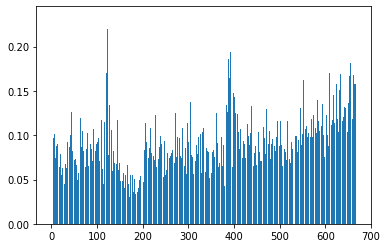

In [144]:
if envs['deviceID'] == 'FF548D29':
    check_index = ['index', 'degrading_level']
else:
    check_index = ['label', 'degrading_level']

_result = X_rawdata_rmse[check_index]
# _result.hist()
# fig, ax = plt.subplots()
# plt.plot(_result['label'], _result['degrading_level'])
plt.bar(x=_result[check_index[0]], height=_result[check_index[1]])

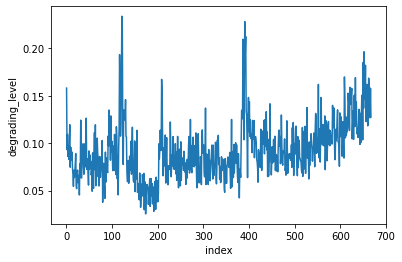

In [145]:
import seaborn as sns
# sns.pairplot(_result, hue='label', size=2.5);
# sns.pairplot(_result, size=4);
sns.lineplot(data=_result, 
             x=check_index[0], 
             y=check_index[1], 
             )

In [ ]:
# 將數據分割成十分鐘一筆
X_rawdata_rmse_deltatime = get_data_by_deltatime(X_rawdata_rmse ,'10min')
X_rawdata_rmse_deltatime = X_rawdata_rmse_deltatime.reset_index()
X_rawdata_rmse_deltatime = X_rawdata_rmse_deltatime[final_order]

In [ ]:
X_rawdata_rmse_deltatime

In [ ]:
# 上傳推理過後的 training data至 aifsphm.deviceID (rawdata+degrading level = 39 columns)
# *參考* https://wise-paas.advantech.com/zh-tw/marketplace/product/advantech.aifs-phm
'''upload_to_postgresDB(config['deviceID'] ,X_rawdata_rmse_deltatime)'''

# 上傳經過preprocessed之ts, Z_OAVelocity, degrading_level至aifsphm.deviceID_predict

In [ ]:
def phm_data_cleaning(data):
    '''1. Feature selection
       2. Time format conversion: UTC -> Local time
       3. Sort data by time, and remove data that overlaps in time
       4. Remove nan value
    '''
    col = ['ts', 'Z_OAVelocity', 'degrading_level']
    # data['ts'] = data['ts'] + datetime.timedelta(hours=8)
    
    # Sort data by time, and remove data that overlaps in time
    data = data.sort_values(by = 'ts', ascending=True)
    data.drop_duplicates("ts", "first", inplace = True)
    # Remove nan value
    data  = data.dropna(axis = 0, how = 'any')
    
    return data

def preprocess_historical(day_data):
    time = []
    rms = []
    rmse = []
    col = ['ts', 'Z_OAVelocity', 'degrading_level']
    for ii in range(len(day_data)):
        time1 = day_data[ii].iloc[0, 0]
        rms_sort = sorted(day_data[ii].Z_OAVelocity,reverse=True)
        rmse_sort = sorted(day_data[ii].degrading_level,reverse=True)
        rms_max = max(rms_sort[(round(len(day_data[ii])*0.1)):])
        rmse_max = max(rmse_sort[(round(len(day_data[ii])*0.1)):])
        time.append(time1), rms.append(rms_max), rmse.append(rmse_max)
    preprocess_data = pd.DataFrame([time, rms, rmse]).T
    preprocess_data.columns = col
    return preprocess_data

In [ ]:
data2 = phm_data_cleaning(X_rawdata_rmse_deltatime)
traindata_day = 1
for i in range(len(data2)-1):
    if data2['ts'].iloc[i].date() != data2['ts'].iloc[i+1].date():
        traindata_day = traindata_day + 1
            
# 創建空list, dataframe
day_data = {}
day_lst = {}
for v in range(traindata_day):
    day_data[v] = pd.DataFrame(columns=range(3))
    day_lst[v] = []
    
# 每天的時間長度可能不同，因此不同天存入不同的list, dataframe
traindata_day_index = 0
for i in range(len(data2)-1):
    if data2['ts'].iloc[i].date() == data2['ts'].iloc[i+1].date():
        day_lst[traindata_day_index].append(data2.iloc[i, :])
        day_data[traindata_day_index] = pd.DataFrame(day_lst[traindata_day_index])
    else:
        day_lst[traindata_day_index].append(data2.iloc[i, :])
        day_data[traindata_day_index] = pd.DataFrame(day_lst[traindata_day_index])
        traindata_day_index = traindata_day_index + 1
        
day_lst[traindata_day_index].append(data2.iloc[len(data2)-1, :])
day_data[traindata_day_index] = pd.DataFrame(day_lst[traindata_day_index])

In [ ]:
data2['ts'].iloc[i].date()

In [ ]:
preprocessed_df = preprocess_historical(day_data)

In [ ]:
upload_preprocessed_to_postgresDB(config['deviceID'],preprocessed_df)